In [1]:
import seaborn as sns
import json
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import re
import pathlib 

from data import get_source_triggers, split_by_intent

colors = ['#7f3b08','#b35806','#e08214','#fdb863','#8e0152','#d73027','#4575b4','#b2abd2','#8073ac','#542788','#2d004b']
# intents_and_functions = ['play_radio', "FindManager", 'email_query', "Tomorrow", 'email_querycontact', "PlaceHasFeature", 'general_quirky', "DoNotConfirm", 'traffic', "FenceAttendee", "total"]
intents_and_functions = [50, "FindManager", 15, "Tomorrow", 16, "PlaceHasFeature", 27, "DoNotConfirm", 66, "FenceAttendee", "total"]
color_mapping = {k:v for k,v in zip(intents_and_functions, colors)}


In [2]:
from dataflow.core.lispress import parse_lispress, render_compact
from dataflow.leaderboard.evaluate import evaluate_prediction_exact_match 
from dataflow.core.turn_prediction import TurnPrediction, TurnAnswer
from dataflow.core.dialogue import TurnId, ProgramExecutionOracle

def get_accuracy_intent(pred_file, intent, triggers, invert=False):
    try:
        with open(pred_file) as f1:
            pred_data = json.load(f1)
    except FileNotFoundError:
        print(f"file {pred_file} doesn't exist")
        return np.nan, [], [], 0
    #with open(data_file) as f1:
    
    total = 0
    correct_examples = []
    incorrect_examples = []

    for example in pred_data:
        true_label = example['true']
        source = re.split("\s+", example['input']) 
        has_trigger = any([t in source for t in triggers])
        
        if not invert:
            if true_label != intent and has_trigger: 
                max_pred = np.argmax(example['pred'])
                total += 1
                if max_pred == true_label: 
                    correct_examples.append(example)
                else:
                    incorrect_examples.append(example)
        
            else:
                continue
        else:
            if true_label == intent or not has_trigger: 
                max_pred = np.argmax(example['pred'])
                total += 1
                if max_pred == true_label: 
                    correct_examples.append(example)
                else:
                    incorrect_examples.append(example)
        
            else:
                continue


    try:
        acc = len(correct_examples)/total 
    except ZeroDivisionError:
        return np.nan, [], [], 0
    # print(f"{pred_file} has total {total}")
    return acc, correct_examples, incorrect_examples, total

def get_accuracy_calflow(pred_tgt, true_src, true_tgt, fxn, triggers, invert=False):
    # print(len(true_src), len(true_tgt), len(pred_tgt))
    assert(len(true_src) == len(true_tgt) == len(pred_tgt))

    total = 0
    correct_examples = []
    incorrect_examples = []

    for pred, src, tgt in zip(pred_tgt, true_src, true_tgt):
        pred, src, tgt = pred.strip(), src.strip(), tgt.strip() 
        try:
            pred_str = render_compact(parse_lispress(pred))
        except:
            pred_str = "(ERROR)"
        true_str = render_compact(parse_lispress(tgt))
        pred = TurnPrediction(TurnId("test", 0), src, pred_str)
        true = TurnAnswer(TurnId("test", 0), src, true_str, ProgramExecutionOracle(False, True))

        match, match_no_refer = evaluate_prediction_exact_match(pred, true)

        is_correct = match

        tgt_tok = re.split("\s+", tgt)
        src_tok = re.split("\s+", src)
        has_fxn = fxn in tgt_tok
        has_trigger = any([t in src_tok for t in triggers])
        if not invert:
            if not has_fxn and has_trigger:
                total += 1
                if is_correct:
                    correct_examples.append((pred, src, tgt))
                else:
                    incorrect_examples.append((pred, src, tgt))
        else:
            if has_fxn and not has_trigger:
                total += 1
                if is_correct:
                    correct_examples.append((pred, src, tgt))
                else:
                    incorrect_examples.append((pred, src, tgt))

    try:
        acc = len(correct_examples)/total 
    except ZeroDivisionError:
        return np.nan, [], [], 0
    return acc, correct_examples, incorrect_examples, total  

In [3]:
%%capture 

def collect_intent(paths_and_types, splits = [750, 1500, 3000, 7500, 15000, 18000], fxn_splits = [15, 30, 75], intents=[50, 66, 16, 27, 15], seeds=[12, 31, 64], 
                    train_data_path = "/home/estengel/incremental-function-learning/intent/data/nlu_eval_data/"):

    df = pd.DataFrame(columns=["fxn", "type", "train", "examples", "seed", "acc", "total"], dtype=object) 
    lookup={"15": "email_q", "16": "email_qc", "27": "quirky", "50": "play_radio", "66": "traffic" }

    for path, type_name in paths_and_types:
        path = pathlib.Path(path)
        for intent in intents:
            for seed in seeds:
                for split in splits:
                    for fxn_split in fxn_splits:
                        pred_path = path.joinpath(str(intent), f"{seed}_seed", f"{split}_{fxn_split}", "test_predictions.json")
                        train_data, __, __ = split_by_intent(train_data_path, intent, split, fxn_split)
                        triggers = get_source_triggers(train_data, intent)
                        acc_has_trigger_no_fxn, correct, incorrect, total = get_accuracy_intent(pred_path, intent, triggers)
                        acc_no_trigger_has_fxn, correct, incorrect, total = get_accuracy_intent(pred_path, intent, triggers,invert=True)
                        
                        df = df.append({"fxn": lookup[str(intent)], "train": str(split), "examples": fxn_split, "type": type_name, "seed": seed, "acc_has_trigger_no_fxn": acc_has_trigger_no_fxn, "acc_no_trigger_has_fxn": acc_no_trigger_has_fxn, "total": total}, ignore_index=True)
    return df 


df2 = collect_intent([("/brtx/603-nvme1/estengel/intent_fixed_test/intent/", "baseline"), 
                     ("/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/", "no dilution")])


There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57

In [ ]:
%%capture  

trigger_lookup = {"FindManager": ["boss", "manager", "supervisor"],
                  "Tomorrow": ["tomorrow"],
                  "DoNotConfirm": ["cancel", "n't", "no"],  
                  "PlaceHasFeature": ["takeout","casual","waiter"],
                  "FenceAttendee": ["mom", "meet"]}

def collect_calflow(paths_and_types, splits = [5000, 10000, 20000, 50000, 100000, "max"], fxn_splits = [100], fxns=["FindManager", "Tomorrow", "DoNotConfirm", "FenceAttendee", "PlaceHasFeature"], seeds=[12, 31, 64], 
                    train_data_path = "/brtx/601-nvme1/estengel/resources/data/smcalflow.agent.data/"):

    df = pd.DataFrame(columns=["fxn", "type", "train", "examples", "seed", "acc", "total"], dtype=object) 

    train_data_path = pathlib.Path(train_data_path)    

    true_tgt_path = train_data_path.joinpath("test_valid.tgt")
    true_src_path = train_data_path.joinpath("test_valid.src")
    with open(true_src_path) as tsf, open(true_tgt_path) as ttf:
        true_src = tsf.readlines()
        true_tgt = ttf.readlines()

    for path, type_name in paths_and_types:
        path = pathlib.Path(path)
        for fxn in fxns:
            for seed in seeds:
                for split in splits:
                    for fxn_split in fxn_splits:
                        pred_tgt_path = path.joinpath(f"{fxn}_{split}_{fxn_split}_{seed}_seed_test_valid.tgt") 
                        if not pred_tgt_path.exists():
                            pred_tgt_path = path.joinpath(f"{fxn}_{seed}_{split}_{fxn_split}_test_valid.tgt") 
                            if not pred_tgt_path.exists():
                                print(f"Missing {pred_tgt_path}")
                                continue
                        with open(pred_tgt_path) as ptf:
                            pred_tgt = ptf.readlines()
                        triggers = trigger_lookup[fxn]
                        acc_has_trigger_no_fxn, correct, incorrect, total = get_accuracy_calflow(pred_tgt, true_src, true_tgt, fxn, triggers)
                        acc_no_trigger_has_fxn, correct, incorrect, total = get_accuracy_calflow(pred_tgt, true_src, true_tgt, fxn, triggers, invert=True)
                        # if np.isnan(acc_no_trigger_has_fxn): 
                        #     acc_no_trigger_has_fxn = -1 

                        df = df.append({"fxn": fxn, "train": str(split), "examples": fxn_split, "type": type_name, "seed": seed, "acc_has_trigger_no_fxn": acc_has_trigger_no_fxn, "acc_no_trigger_has_fxn": acc_no_trigger_has_fxn, "total": total}, ignore_index=True)
    return df 


collect_calflow([("/home/estengel/papers/incremental_function_learning/results/transformer", "baseline"),
                              ("/home/estengel/papers/incremental_function_learning/results/no_source", "no_source")], 
                              fxns=['PlaceHasFeature'])
                            #   fxns=["FenceAttendee", "FindManager", "DoNotConfirm", "PlaceHasFeature", "Tomorrow"])

# calflow_df = pd.read_csv("/home/estengel/papers/incremental_function_learning/results/calflow_df.csv")

In [ ]:
# calflow_df.to_csv("/home/estengel/papers/incremental_function_learning/results/PlaceHasFeature_calflow_df.csv")
calflow_df = pd.read_csv("/home/estengel/papers/incremental_function_learning/results/PlaceHasFeature_calflow_df.csv")

/home/estengel/miniconda3/envs/miso/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


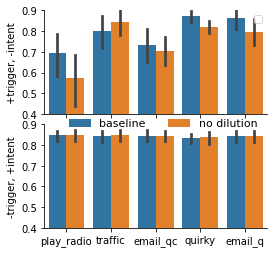

In [25]:

fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.1})

intent_df = df2[df2['examples']==30]

sns.barplot(data=intent_df,  x="fxn", y = "acc_has_trigger_no_fxn", hue="type", ax=ax[0]) #, palette=color_mapping)
sns.barplot(data=intent_df,  x="fxn", y = "acc_no_trigger_has_fxn", hue="type", ax=ax[1]) #, palette=color_mapping)
ax[0].set_ylim(0.4, 0.9)
ax[1].set_ylim(0.4, 0.9)
ax[0].set_xlabel("")
ax[0].legend([],[])
ax[1].legend(**{"fontsize": 11, "frameon": False, "ncol": 2, "loc": 1, "bbox_to_anchor": (1.0, 1.15)})
sns.despine()

ax[0].set_ylabel("+trigger, -intent")
ax[1].set_ylabel("-trigger, +intent")
ax[1].set_xlabel("")

# plt.xticks(rotation=45)


plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/difficult_examples_intent.pdf")


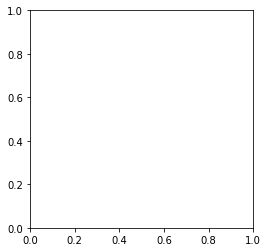

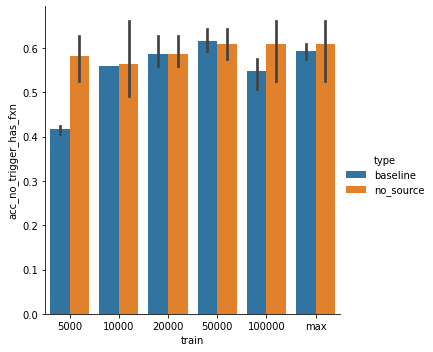

In [41]:

fig, ax = plt.subplots(1,1, figsize=(4,4))
# print(calflow_df[calflow_df['type'] == 'baseline'])
sns.catplot(data=calflow_df, kind='bar', x="train", y = "acc_no_trigger_has_fxn", hue="type") #, palette=color_mapping)
sns.despine()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/difficult_examples_calflow.pdf")


In [44]:
print(calflow_df['acc_has_trigger_no_fxn'])

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
Name: acc_has_trigger_no_fxn, dtype: float64


In [46]:
with open("data/nlu_eval_data/train.json") as f1:
    train_data = json.load(f1) 

has_trigger = 0
is_50 = 0
for d in train_data:
    if d['label'] == 50:
        is_50+=1
        for t in ["radio", "fm", "play"]:
            if t in d['text'].split(' '):
                has_trigger += 1
                break

print(f"{has_trigger / is_50 * 100 :.2f}")

78.04
